In [1]:
import sys 
sys.path.append('..')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import dropna_pearsonr
from utils.df_preprocessing import get_real_grid_comparison, plot_total_real_grid_comparison
from climate.data_preprocessing import load_data

pd.options.mode.chained_assignment = None  # default='warn'

Load data:

In [3]:
characteristics = ['precipitation', 'temperature', 'vpd']

In [4]:
data_real = load_data(path='../input/climate/real', characteristics=characteristics)
data_grid = load_data(path='../input/climate/grid', characteristics=characteristics)

In [5]:
mon_ru = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
mon_en = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
mon_dict = {en:ru for en, ru in zip(mon_en, mon_ru)}

In [6]:
def compare_dfs(df1, df2):
    years = list(set(df1['Year']) & set(df2['Year']))
    min_y, max_y = years[0], years[-1]
    corrs = dict()

    for month in range(1,13):
        x_ = df1[(df1['Year']>=min_y) & (df1['Year']<=max_y)].iloc[:,month]
        y_ = df2[(df2['Year']>=min_y) & (df2['Year']<=max_y)].iloc[:,month]
        corrs[month] = dropna_pearsonr(x_, y_)
    
    return corrs

def compare_to_xlsx(df1, df2, name):
    corrs = pd.DataFrame(compare_dfs(df1, df2))
    corrs = corrs.transpose()
    corrs = corrs.rename(columns={0:'Корреляция', 1:'p-value'})
    wr = 'output/DF_Comparison.xlsx'
    try:
        with pd.ExcelWriter(wr, mode='a') as writer:
            corrs.to_excel(writer, sheet_name=name)
    except FileNotFoundError:
        corrs.to_excel(wr, sheet_name=name)

In [ ]:
compare_to_xlsx(grid_temp_C, mean_temp_C, 'Chok_Temp')
compare_to_xlsx(grid_prec_C, mean_prec_C, 'Chok_Prec')
compare_to_xlsx(grid_temp_H, mean_temp_H, 'Khat_Temp')
compare_to_xlsx(grid_prec_H, mean_prec_H, 'Khat_Prec')
compare_to_xlsx(grid_temp_I, mean_temp_I, 'Inuvik_Temp')
compare_to_xlsx(grid_prec_I, grid_prec_I, 'Inuvik_Prec')

In [5]:
stations = ['Chokurdakh', 'Khatanga', 'Inuvik']

char2label = {
    'Temp':'Average temperature (°C)',
    'Prec':'Total precipitation\n (mm)',
    'VPD': 'Average\n vapour pressure deficit\n (mbar)'
}

ylims = {
    'Temp':[-18, -4],
    'Prec':[50, 420],
    'VPD': [1,5]
}

char2mean_method = {
    'Temp': 'mean',
    'Prec': 'sum',
    'VPD': 'mean'
}

[]

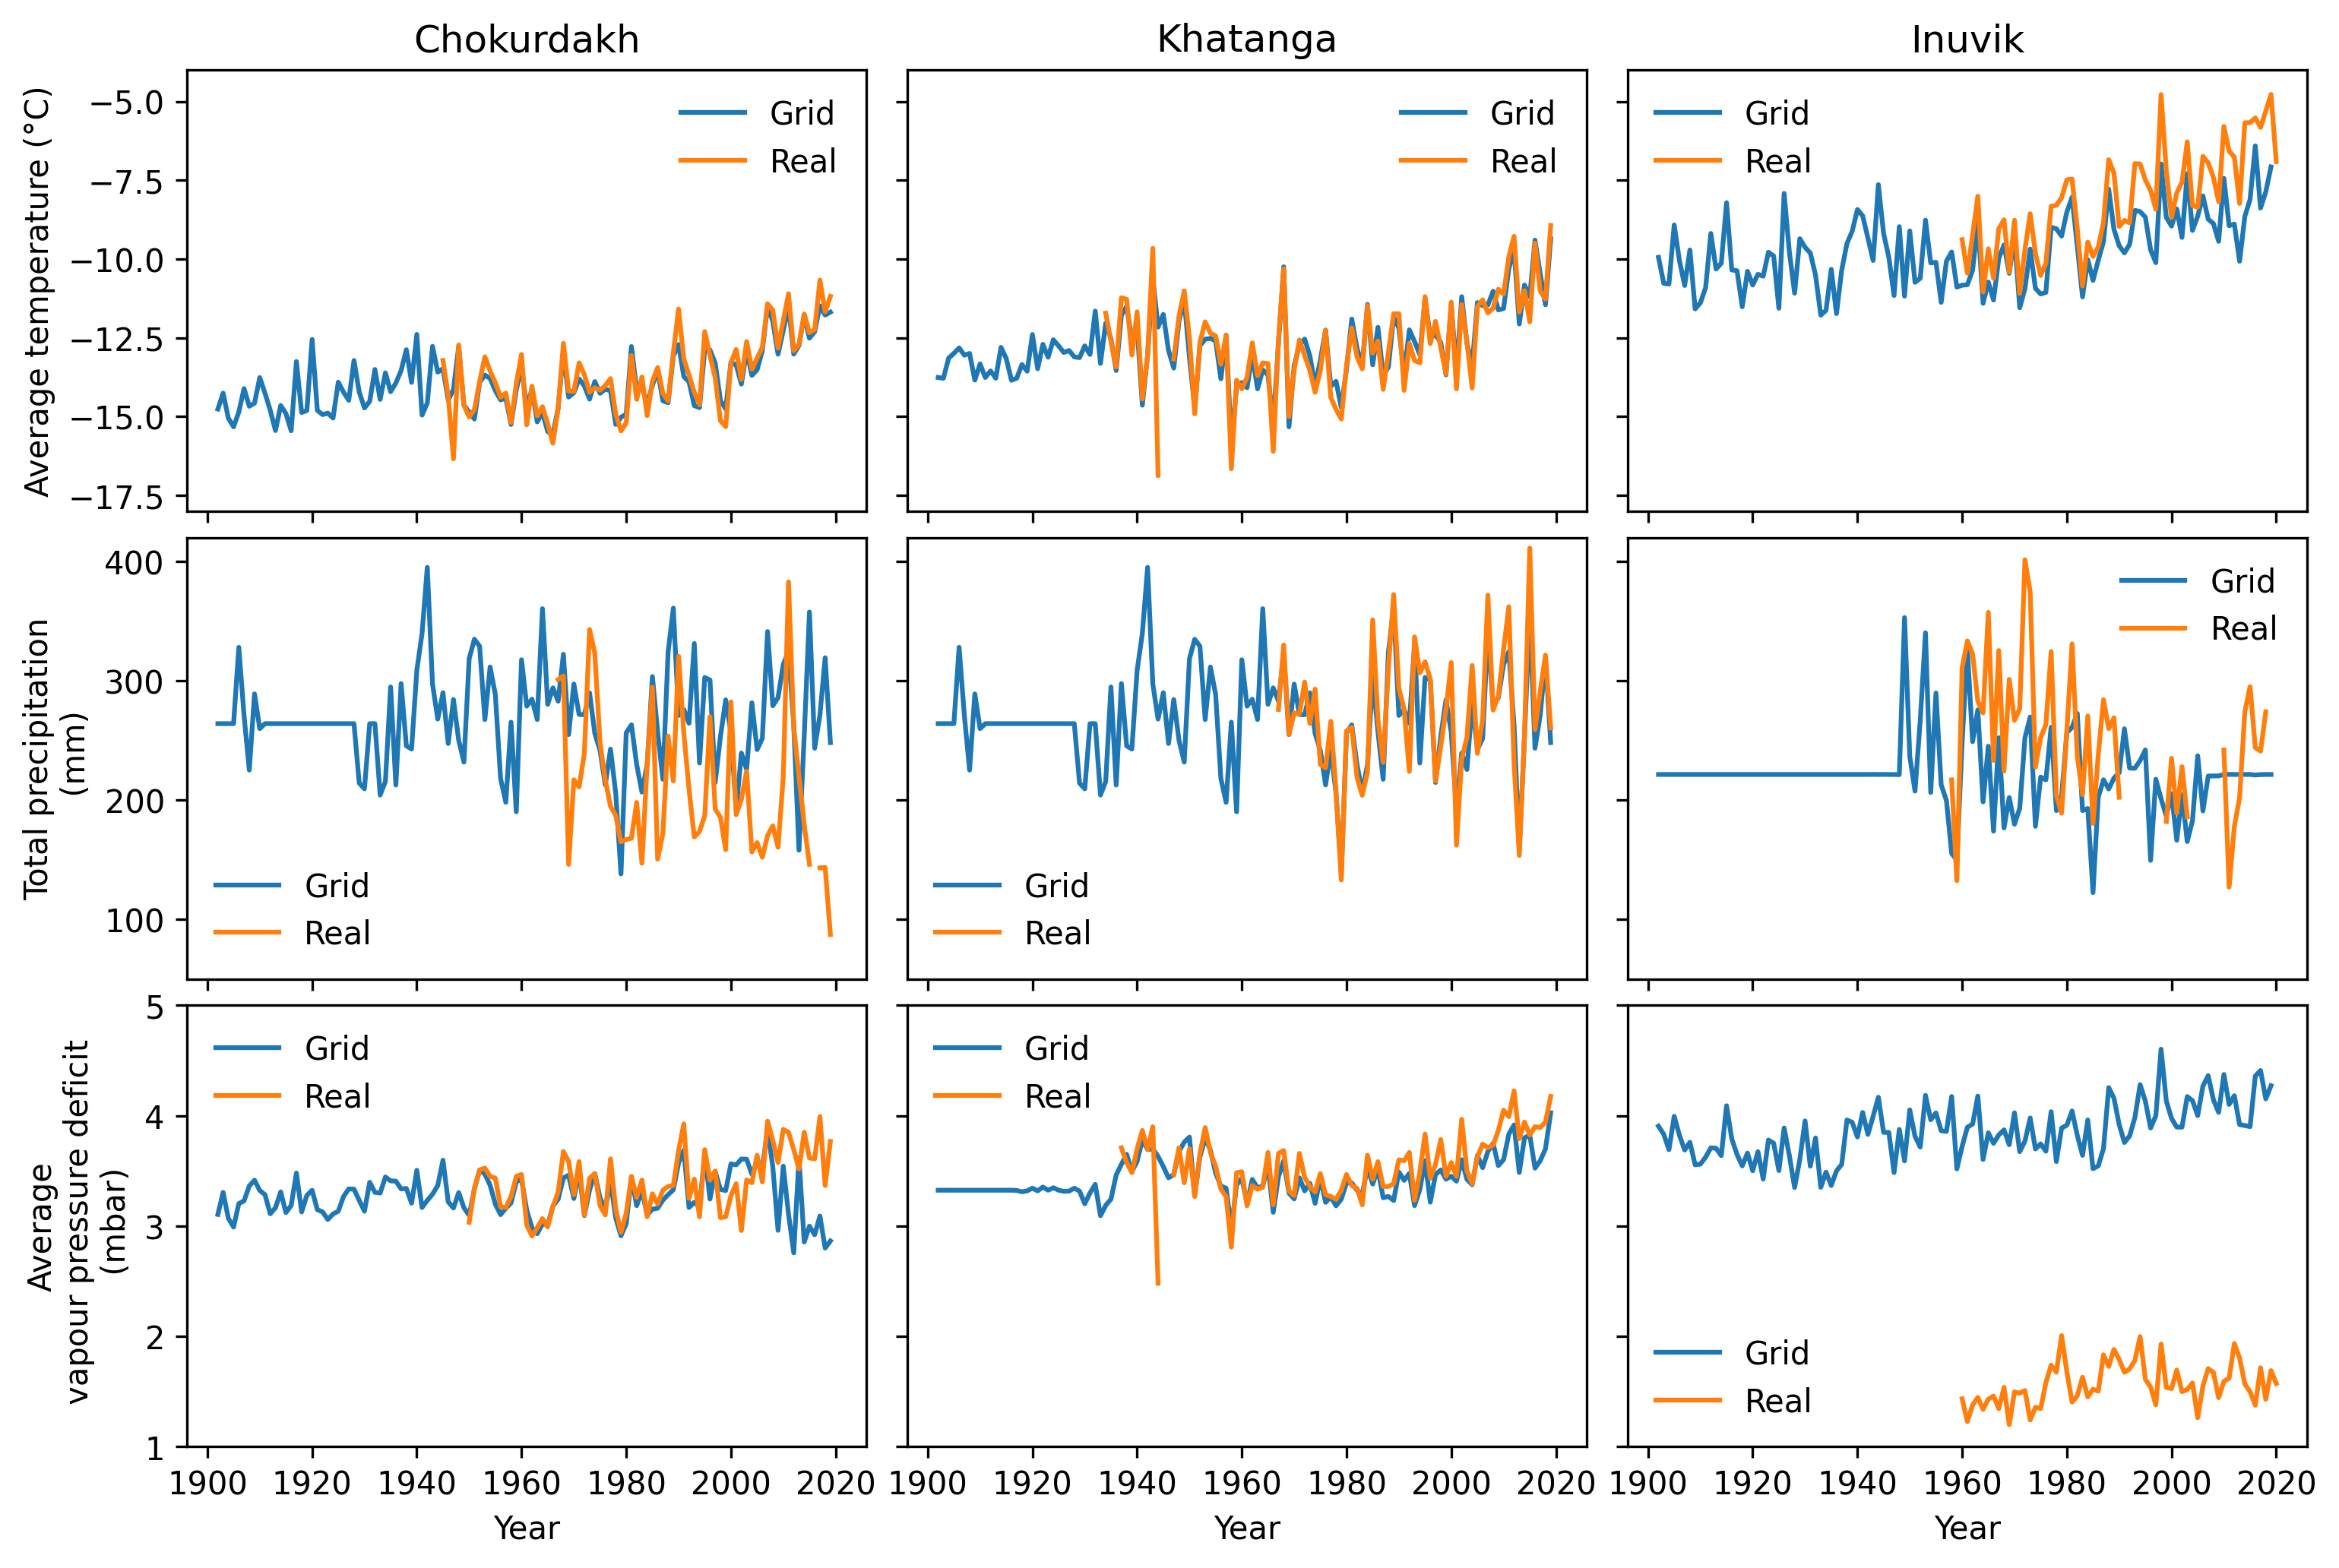

In [15]:
fig, axes = plot_total_real_grid_comparison(data_real, data_grid, stations, char2label, char2mean_method, ylims)
plt.plot()

In [ ]:
plt.savefig(f'../output/Figure S1.png', dpi=300)
plt.close(fig)

In [13]:
from utils.functions import dropna_pearsonr, dropna

In [14]:
for i, char in enumerate(char2label):
        for j, station in enumerate(stations):
            key = f'{char}_{station}'
            loc_real = data_real[key]
            loc_grid = data_grid[key]
            years, real, grid = get_real_grid_comparison(loc_real, loc_grid, char2mean_method[char])
            rea,gri = dropna(real, grid)
            r, p = dropna_pearsonr(real, grid)
            print(f'{key}: r = {r:.2f}, p = {p:.6f}, N = {len(rea)}')

Temp_Chokurdakh: r = 0.90, p = 0.000000, N = 76
Temp_Khatanga: r = 0.90, p = 0.000000, N = 86
Temp_Inuvik: r = 0.92, p = 0.000000, N = 60
Prec_Chokurdakh: r = 0.21, p = 0.138052, N = 52
Prec_Khatanga: r = 0.92, p = 0.000000, N = 53
Prec_Inuvik: r = 0.65, p = 0.000001, N = 47
VPD_Chokurdakh: r = 0.34, p = 0.003968, N = 71
VPD_Khatanga: r = 0.75, p = 0.000000, N = 81
VPD_Inuvik: r = 0.32, p = 0.011675, N = 60
